In [2]:
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html
import random

def get_random_node_uniform(rng, a_huge_key_list):
    L = len(a_huge_key_list)
    i = rng.integers(0, L)
    return a_huge_key_list[i]

def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None


def update_opinions(u, v, opinions, convergence, symmetric_updating=True):
    diff = opinions[u] - opinions[v]

    opinions[u] -= convergence * diff
    
    if symmetric_updating:
        opinions[v] += convergence * diff
        
    return opinions

def effective_neighbors(u, adjG, opinions, threshold):
    
    distances = opinions - opinions[u] # vector of opinion distances
    distances[(distances < -threshold) | (distances > threshold)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0
    
    return adjG[u]*distances # filters out non-neighbors with close opinion distance


def update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating):
    
    neighbors = effective_neighbors(u, adjG, opinions, threshold)

    effective_net[u]   = neighbors
    effective_net[:,u] = neighbors
        
    if not symmetric_updating:
        return effective_net

    neighbors = effective_neighbors(v, adjG, opinions, threshold)
    
    effective_net[v]   = neighbors
    effective_net[:,v] = neighbors
            
    return effective_net

def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float, convergence: float, initial_opinions=None,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42)):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize opinions
    if initial_opinions is None:
        opinions = rng.random(G.order())
    else:
        opinions = np.copy(initial_opinions)
    # save adjacency matrix
    adjG = nx.to_numpy_array(G)

    # get initial effective network
    effective_net = np.copy(adjG)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[u]   = neighbors
        effective_net[:,u] = neighbors

    if not fast_mode:
        # initialize the list of nets that will be returned
        network_history = [effective_net]
        opinion_history = [opinions]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = np.copy(network_history[t-1])
            opinions      = np.copy(opinion_history[t-1])

        # choose random node to update
        u = rng.choice(G.order())
        
        # get another node if u is isolated
        while not effective_net[u].sum():
            u = rng.choice(G.order())
        
        # get a random neighbor of u
        v = get_random_node_uniform(rng, np.argwhere(effective_net[u]==1))[0]

        # update their opinions
        opinions = update_opinions(u, v, opinions, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            network_history.append(effective_net)
            opinion_history.append(opinions)
    
    if fast_mode:
        return effective_net, opinions
    else:
        return network_history, opinion_history

def effective_network(G,threshold,opinions):
    adjG = nx.to_numpy_array(G)
    effective_net = np.copy(adjG)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[u]   = neighbors
        effective_net[:,u] = neighbors
    return effective_net

def compute_iterations(symmetric_updating,iterations,net_order):
    if symmetric_updating==True:
        time = iterations/(net_order/2)
    else:
        time = iterations/net_order
    return time

def degree_distribution(G):
    adjG = nx.to_numpy_array(G)
    degrees = np.zeros(net_order)
    meandegree = 0

    for i in range(0,len(adjG[0])):
        degrees[i] = np.sum(adjG[:,i])

    degmax = int(np.max(degrees))
    degmin = int(np.min(degrees))
    dim = degmax-degmin+1
    degree_distrib = np.zeros((dim,2))

    for j in range(0,dim):
        degree_distrib[j,1] =  j+degmin

    for i in range(0,net_order):
        for j in range(0,dim):
            if(degrees[i]==(j+degmin)):
                degree_distrib[j,0] =  degree_distrib[j,0]+1
    for i in range(0,degmax-degmin+1):
        meandegree = meandegree + degree_distrib[i,0]*degree_distrib[i,1]
    meandegree = meandegree/net_order
    return degree_distrib,meandegree,dim



def create_network(N, p):
    G = nx.Graph()
    nodes_degree_5 = int(N * p)
    nodes_degree_100 = N - nodes_degree_5
    
    # Create nodes with degree 5
    for i in range(nodes_degree_5):
        G.add_node(i, degree=5)
    
    # Create nodes with degree 100
    for i in range(nodes_degree_5, N):
        G.add_node(i, degree=100)
    
    # Connect nodes randomly
    nodes = list(G.nodes())
    for i in range(N):
        if G.nodes[i]['degree'] == 5:
            for _ in range(5):
                j = random.choice(nodes)
                if i != j and not G.has_edge(i, j):
                    G.add_edge(i, j)
        else:
            for _ in range(100):
                j = random.choice(nodes)
                if i != j and not G.has_edge(i, j):
                    G.add_edge(i, j)
    
    return G


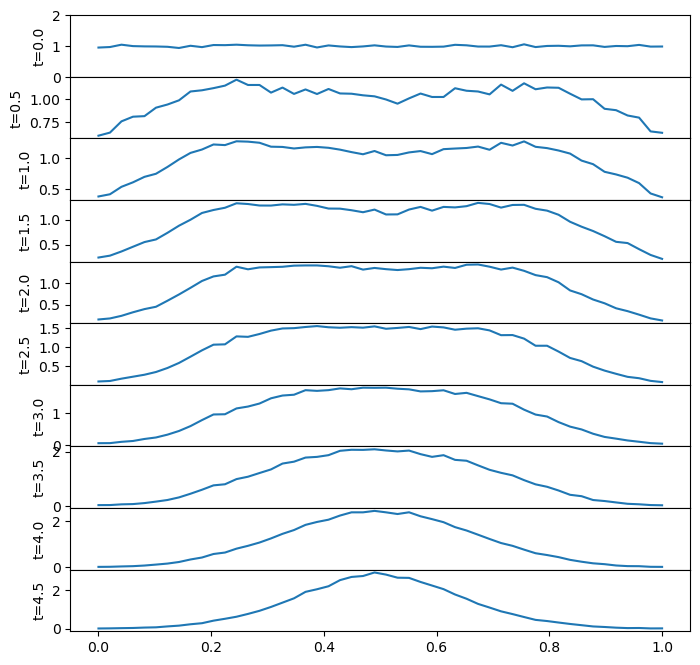

Hasta aqui


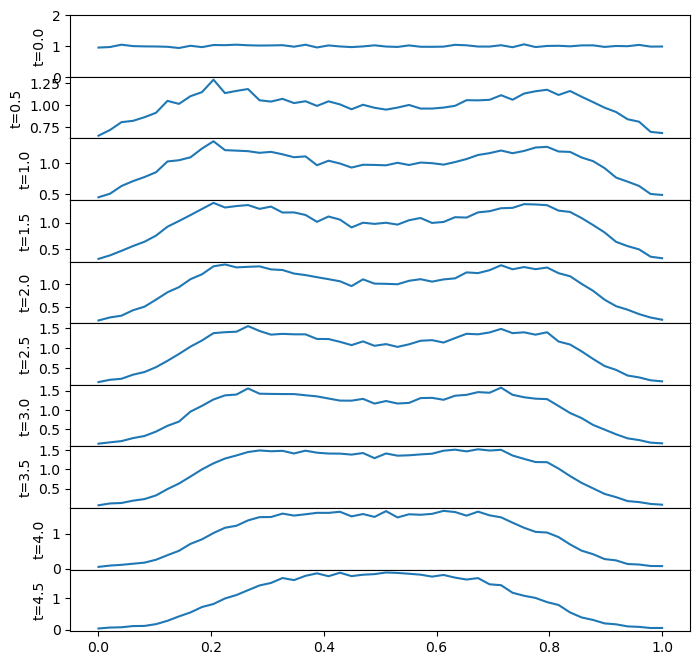

In [3]:
##Código original separando 1 y 2 clusters formados
#Values
net_order = 1000
symmetric_updating = False
iterations = 500
average = 50
times = 10
bins = 50
threshold = 0.4
convergence = 0.5

#Initialize
G = create_network(net_order,p=0.9)
opinionshist = np.zeros((average,bins,times))
opinionshist1 = np.zeros((average,bins,times))
opinionfinal1 = np.zeros((bins,times))
opinionshist2 = np.zeros((average,bins,times))
opinionfinal2 = np.zeros((bins,times))
initialopinions = np.zeros((net_order,average))
time = compute_iterations(symmetric_updating,iterations,net_order)
rng = np.random.default_rng()
maximos = np.zeros(average)
xaxis = np.linspace(start=0,stop=1,num=bins+1)
numd1 = numd2 = 0

#Initialize graph
#fig,ax = plt.subplots(times,2,figsize=(20,10))

#Loop for the average over the net_order nodes keeping the opinions at certain times
for i in range(0,average):
    opinions = rng.random(G.order())
    opinionshist[i,:,0] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
    initialopinions[:,i]=np.copy(opinions)
    for j in range(1,times):
        _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence,
                                                initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                fast_mode=True,rng=np.random.default_rng())
        opinionshist[i,:,j] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]

    ind = 0
    for k in range(0,bins):
        if(opinionshist[i,k,times-1]>=ind):
            maximos[i] = k
            ind = opinionshist[i,k,times-1]
    indice = int(maximos[i])
    if(0.4<xaxis[indice]<0.6):
        opinionshist1[numd1,:,:] = np.copy(opinionshist[i,:,:])
        numd1 = numd1+1
    else:
        opinionshist2[numd2,:,:] = np.copy(opinionshist[i,:,:])
        numd2 = numd2+1

'''
# Writing the vector data to a text file
with open('t0False.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 0],6)) + '\t')
        file.write('\n')

with open('t1False.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 1],6)) + '\t')
        file.write('\n')

with open('t2False.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 2],6)) + '\t')
        file.write('\n')
        
with open('t3False.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 3],6)) + '\t')
        file.write('\n')
        
with open('t4False.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 4],6)) + '\t')
        file.write('\n')
'''
        
fig,ax = plt.subplots(times,1,figsize=(8,8))
ax[0].set_ylim(0,2)

for j in range(0,times):
    opinionfinal = np.mean(opinionshist,axis=0)
    ax[j].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal[:,j])
    ax[j].set_ylabel("t={}".format(np.round(j*time,4)))

plt.subplots_adjust(hspace=0)
plt.savefig('Time evolution Asym')
plt.show()

print('Hasta aqui')
symmetric_updating = True
iterations = 250
opinionshist = np.zeros((average,bins,times))
time = compute_iterations(symmetric_updating,iterations,net_order)
maximos = np.zeros(average)
numd1 = numd2 = 0

for i in range(0,average):
    opinions = np.copy(initialopinions[:,i])
    opinionshist[i,:,0] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
    for j in range(1,times):
        _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence,
                                                initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                fast_mode=True,rng=np.random.default_rng())
        opinionshist[i,:,j] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]

'''
print('Hasta aqui2')
# Writing the vector data to a text file
with open('t0True.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 0],6)) + '\t')
        file.write('\n')

with open('t1True.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 1],6)) + '\t')
        file.write('\n')

with open('t2True.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 2],6)) + '\t')
        file.write('\n')
        
with open('t3True.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 3],6)) + '\t')
        file.write('\n')
        
with open('t4True.txt', 'w') as file:
    for bin_idx in range(bins):
        file.write(f'{xaxis[bin_idx]}\t')
        for avg_idx in range(average):
            file.write(str(np.round(opinionshist[avg_idx, bin_idx, 4],6)) + '\t')
        file.write('\n')
'''

fig,ax = plt.subplots(times,1,figsize=(8,8))
ax[0].set_ylim(0,2)

for j in range(0,times):
    opinionfinal = np.mean(opinionshist,axis=0)
    ax[j].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal[:,j])
    ax[j].set_ylabel("t={}".format(np.round(j*time,4)))

plt.subplots_adjust(hspace=0)
plt.savefig('Time evolution Sym')
plt.show()

In [31]:
##Cálculo del tiempo hasta llegar al estacionario
#Values
import time
net_order = np.array([300,500,700,900,1000])
symmetric_updating = True
iterations = 200
average = 20
bins = 51
threshold = 0.4
convergence = 0.5

#Initialize
times = compute_iterations(symmetric_updating,iterations,net_order)
rng = np.random.default_rng()
meantime = np.zeros(5)
stdtime = np.zeros(5)
start_time = end_time = 0

#Loop for the average over the net_order nodes keeping the opinions at certain times
for l in range(0,5):
    start_time = time.time()
    print("l es {}".format(l))
    #G = get_net('complete_mixing',net_order=net_order[l],rng=None)
    G = create_network(net_order[l],p=0.9)
    opinionshist = np.zeros((average,bins))
    testacionario = np.zeros(average)
    distclust = np.zeros(average)
    for i in range(0,average):
        opinions = rng.random(G.order())
        print(i)
        indmax = 0
        j=1
        criteria=0
        while(criteria<0.80)or(distclust[i]<threshold):
            _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            opinionshist[i,:] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]/51
            indmax = np.argmax(opinionshist[i,:])
            criteria = opinionshist[i,indmax]
            testacionario[i] = iterations*j
            #print(opinionshist[i,:])
            #if(criteria==1):
            if(abs(criteria - 1) < 1e-8):
                distclust[i] = indmax/(bins-1)
                break
            if(criteria>=0.80):
                #print(opinionshist[i,:],distclust[i])
                for k in range(1,int((bins-1)/2)):
                    if((indmax+k)==51)or((indmax-k)==0):
                        distclust[i] = k/(bins-1)
                        #print(i,k)
                        break
                    if(opinionshist[i,indmax-k]!=0)or(opinionshist[i,indmax+k]!=0):
                        distclust[i] = k/(bins-1)
                        #print(k,distclust[i])
                        break
            j+=1
    meantime[l] = np.mean(testacionario)
    stdtime[l] = np.std(testacionario)
    print("{} ha acabado".format(l))
    end_time = time.time()
    print((end_time-start_time)/60)

print(testacionario)
print(meantime,stdtime)

l es 0
0
1
2
3
4
5
6


KeyboardInterrupt: 

50
300
1000
50
300
1000
50
300
1000
50
300
1000
50
300
1000
50
300
1000


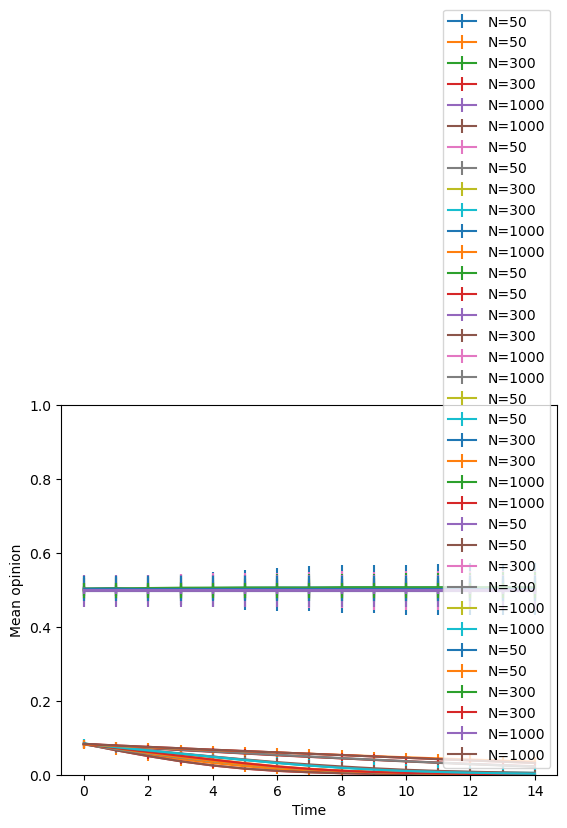

In [3]:
##Estudio media y varianza opiniones respecto al tiempo
net_order = np.array([50,300,1000])
symmetric_updating = False
iterations = np.array([50,300,1000])
average = 50
times = 15
bins = 50
threshold = 0.40
convergence = 0.5
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)
initialopinions50 = np.zeros((average,50,3))
initialopinions300 = np.zeros((average,300,3))
initialopinions1000 = np.zeros((average,1000,3))

for l in range(0,3):
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        opinions = rng.random(G.order())
        if(l==0):
            initialopinions50[i,:,0] = np.copy(opinions)
        if(l==1):
            initialopinions300[i,:,0] = np.copy(opinions)
        if(l==2):
            initialopinions1000[i,:,0] = np.copy(opinions)
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolAsymCon0.5.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolAsymCon0.5.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()


convergence=0.3
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)

for l in range(0,3):
    #Initialize
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        opinions = rng.random(G.order())
        if(l==0):
            initialopinions50[i,:,1] = np.copy(opinions)
        if(l==1):
            initialopinions300[i,:,1] = np.copy(opinions)
        if(l==2):
            initialopinions1000[i,:,1] = np.copy(opinions)
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolAsymCon0.3.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolAsymCon0.3.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()

convergence=0.1
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)

for l in range(0,3):
    #Initialize
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        opinions = rng.random(G.order())
        if(l==0):
            initialopinions50[i,:,2] = np.copy(opinions)
        if(l==1):
            initialopinions300[i,:,2] = np.copy(opinions)
        if(l==2):
            initialopinions1000[i,:,2] = np.copy(opinions)
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolAsymCon0.1.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolAsymCon0.1.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j]*2)+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()
            

symmetric_updating = True
iterations = np.array([25,150,500])
convergence = 0.5
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)

for l in range(0,3):
    #Initialize
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        if(l==0):
            opinions = np.copy(initialopinions50[i,:,0])
        if(l==1):
            opinions = np.copy(initialopinions300[i,:,0])        
        if(l==2):
             opinions = np.copy(initialopinions1000[i,:,0])
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolSymCon0.5.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolSymCon0.5.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()


convergence=0.3
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)

for l in range(0,3):
    #Initialize
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        if(l==0):
            opinions = np.copy(initialopinions50[i,:,1])
        if(l==1):
            opinions = np.copy(initialopinions300[i,:,1])        
        if(l==2):
             opinions = np.copy(initialopinions1000[i,:,1])
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolSymCon0.3.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolSymCon0.3.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()

convergence=0.1
meanopinions = np.zeros((average,times))
finalmeans = np.zeros((times,3))
finalmeansstd = np.zeros((times,3))
varopinions = np.zeros((average,times))
finalvars = np.zeros((times,3))
finalvarsstd = np.zeros((times,3))
rng=np.random.default_rng()
tiempos = np.zeros(times)

for l in range(0,3):
    #Initialize
    G = create_network(net_order[l],p=0.9)
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    print(net_order[l])

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        if(l==0):
            opinions = np.copy(initialopinions50[i,:,2])
        if(l==1):
            opinions = np.copy(initialopinions300[i,:,2])        
        if(l==2):
             opinions = np.copy(initialopinions1000[i,:,2])
        meanopinions[i,0] = np.mean(opinions)
        varopinions[i,0] = np.var(opinions)
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            #print(opinions)
            meanopinions[i,j] = np.mean(opinions)
            varopinions[i,j] = np.var(opinions)
    for j in range(0,times):
        #print(meanopinions[:,j])
        finalmeans[j,l] = np.round(np.mean(meanopinions[:,j]),4)
        finalmeansstd[j,l] = np.round(np.std(meanopinions[:,j]),4)
        finalvars[j,l] = np.round(np.mean(varopinions[:,j]),4)
        finalvarsstd[j,l] = np.round(np.std(varopinions[:,j]),4)
        tiempos[j] = j*time
    plt.errorbar(tiempos,finalmeans[:,l],yerr=finalmeansstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    
    plt.errorbar(tiempos,finalvars[:,l],yerr=finalvarsstd[:,l],label='N={}'.format(net_order[l]))
    plt.xlabel('Time')
    plt.ylabel('Mean opinion')
    plt.legend()
    plt.ylim(0,1)
    


f = open('MeansevolSymCon0.1.txt','w')
f.write('#Times   Mean N50   Std N50   Mean N300   Std N300   Mean N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalmeans[j,0])+'\t'+str(finalmeansstd[j,0])+'\t'+str(finalmeans[j,1])+'\t'+str(finalmeansstd[j,1])+'\t'+str(finalmeans[j,2])+'\t'+str(finalmeansstd[j,2])+'\n')

f.close()

f = open('VarsevolSymCon0.1.txt','w')
f.write('#Times   Var N50   Std N50   Var N300   Std N300   Var N1000   Std N1000\n')
for j in range(0,times):
        f.write(str(tiempos[j])+'\t'+str(finalvars[j,0])+'\t'+str(finalvarsstd[j,0])+'\t'+str(finalvars[j,1])+'\t'+str(finalvarsstd[j,1])+'\t'+str(finalvars[j,2])+'\t'+str(finalvarsstd[j,2])+'\n')

f.close()

19 16
14 102
[0.56435343] [0.5114566]
[0.13769056] [0.05677684]


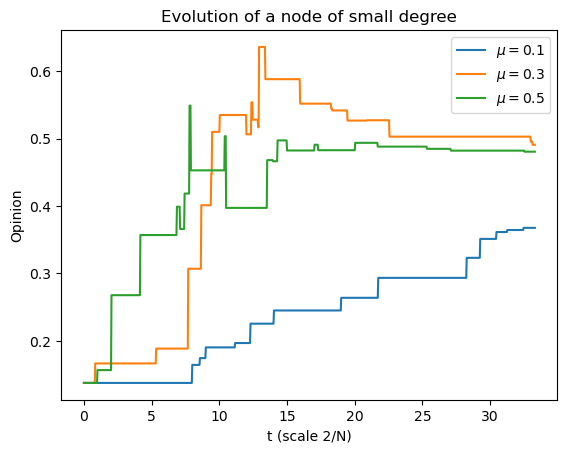

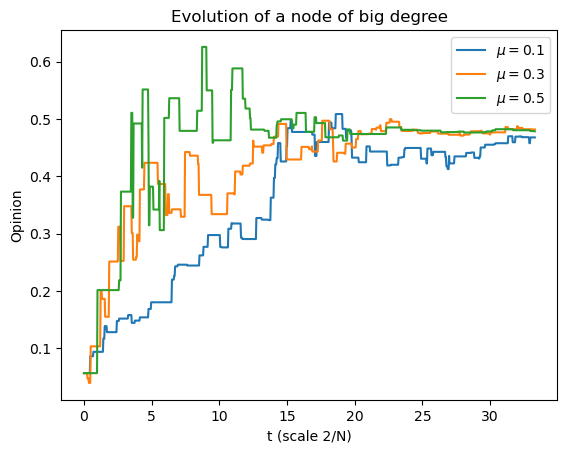

In [31]:
##Estudio de un único nodo de grado alto y de grado bajo
import networkx as nx
net_order = 300
symmetric_updating = True
iterations = 5
average = 1
times = 1000
bins = 50
threshold = 0.4
convergence = np.array([0.1,0.3,0.5])

#Initialize
G = create_network(net_order,p=0.9)
initialopinions = np.zeros((net_order))
rng=np.random.default_rng()
time = compute_iterations(symmetric_updating,iterations,net_order)
opinionnodes = np.zeros((times,2,3))
node1 = np.random.randint(0,net_order,1)
node2 = np.random.randint(0,net_order,1)
t = np.zeros(times)

print(G.degree[node1.item()], G.degree[node2.item()])

while(G.degree[node1.item()] >= 15):
    node1 = np.random.randint(0,net_order,1)
while(G.degree[node2.item()] <= 100):
    node2 = np.random.randint(0,net_order,1)
    
print(G.degree[node1.item()], G.degree[node2.item()])
    
initialopinions = rng.random(G.order())
print(initialopinions[node1],initialopinions[node2])
while (initialopinions[node1]>0.2 and initialopinions[node1]<0.8):
    initialopinions[node1]=np.random.rand()
while (initialopinions[node2]>0.2 and initialopinions[node2]<0.8):
    initialopinions[node2]=np.random.rand()
print(initialopinions[node1],initialopinions[node2])

#Loop for the average over the net_order nodes keeping the opinions at certain times
for i in range(0,3):
    opinions = initialopinions
    opinionnodes[0,0,i] = initialopinions[node1]
    opinionnodes[0,1,i] = initialopinions[node2]
    for j in range(1,times):
        _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence[i],
                                                initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                fast_mode=True,rng=np.random.default_rng())
        opinionnodes[j,0,i] = opinions[node1]
        opinionnodes[j,1,i] = opinions[node2]
        if(i==0):
            t[j] = time*j
plt.plot(t,opinionnodes[:,0,0],label=r"$\mu=0.1$")
plt.plot(t,opinionnodes[:,0,1],label=r"$\mu=0.3$")
plt.plot(t,opinionnodes[:,0,2],label=r"$\mu=0.5$")
plt.title('Evolution of a node of small degree')
plt.xlabel('t (scale 2/N)')
plt.ylabel('Opinion')
plt.legend()
plt.savefig('SmalldegreeSym')
plt.show()

plt.plot(t,opinionnodes[:,1,0],label=r"$\mu=0.1$")
plt.plot(t,opinionnodes[:,1,1],label=r"$\mu=0.3$")
plt.plot(t,opinionnodes[:,1,2],label=r"$\mu=0.5$")
plt.title('Evolution of a node of big degree')
plt.xlabel('t (scale 2/N)')
plt.ylabel('Opinion')
plt.legend()
plt.savefig('BigdegreeSym')
plt.show()

0


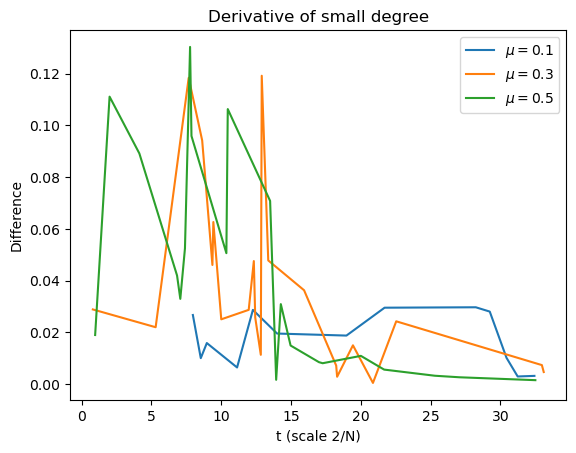

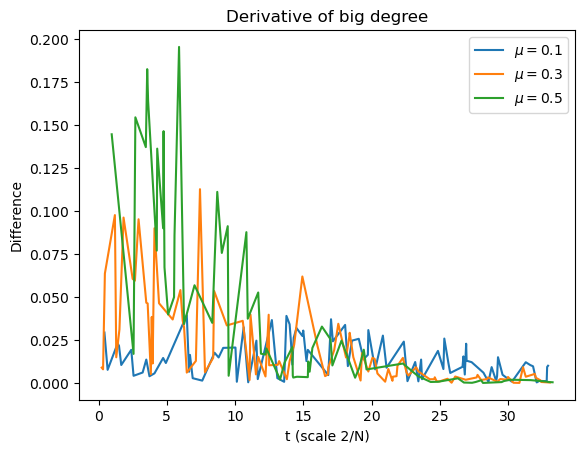

In [32]:
difopinions = np.zeros((times-1,2,3))
times=1000
t00 = []
t01 = []
t02 = []
t10 = []
t11 = []
t12 = []
opin00 = np.zeros(times)
opin01 = np.zeros(times)
opin02 = np.zeros(times)
opin10 = np.zeros(times)
opin11 = np.zeros(times)
opin12 = np.zeros(times)
vect00 = []
vect01 = []
vect02 = []
vect10 = []
vect11 = []
vect12 = []
cont=0
print(len(vect00))
for j in range(0,times-1):
    opin00[j] = abs(opinionnodes[j+1,0,0]-opinionnodes[j,0,0])
    if(opin00[j]>=0.0001):
        vect00.append(opin00[j])
        t00.append(time*j)
    opin01[j] = abs(opinionnodes[j+1,0,1]-opinionnodes[j,0,1])
    if(opin01[j]>=0.0001):
        vect01.append(opin01[j])
        t01.append(time*j)
    opin02[j] = abs(opinionnodes[j+1,0,2]-opinionnodes[j,0,2])
    if(opin02[j]>=0.0001):
        vect02.append(opin02[j])
        t02.append(time*j)
    opin10[j] = abs(opinionnodes[j+1,1,0]-opinionnodes[j,1,0])
    if(opin10[j]>=0.0001):
        vect10.append(opin10[j])
        t10.append(time*j)
    opin11[j] = abs(opinionnodes[j+1,1,1]-opinionnodes[j,1,1])
    if(opin11[j]>=0.0001):
        vect11.append(opin11[j])
        t11.append(time*j)
    opin12[j] = abs(opinionnodes[j+1,1,2]-opinionnodes[j,1,2])
    if(opin12[j]>=0.0001):
        vect12.append(opin12[j])
        t12.append(time*j)

plt.plot(t00,vect00,label=r"$\mu=0.1$")
plt.plot(t01,vect01,label=r"$\mu=0.3$")
plt.plot(t02,vect02,label=r"$\mu=0.5$")
plt.title('Derivative of small degree')
plt.xlabel('t (scale 2/N)')
plt.ylabel('Difference')
plt.legend()
#plt.savefig('SmalldegreeSymDifference')
plt.show()

plt.plot(t10,vect10,label=r"$\mu=0.1$")
plt.plot(t11,vect11,label=r"$\mu=0.3$")
plt.plot(t12,vect12,label=r"$\mu=0.5$")
plt.title('Derivative of big degree')
plt.xlabel('t (scale 2/N)')
plt.ylabel('Difference')
plt.legend()
#plt.savefig('BigdegreeSymDifference')
plt.show()


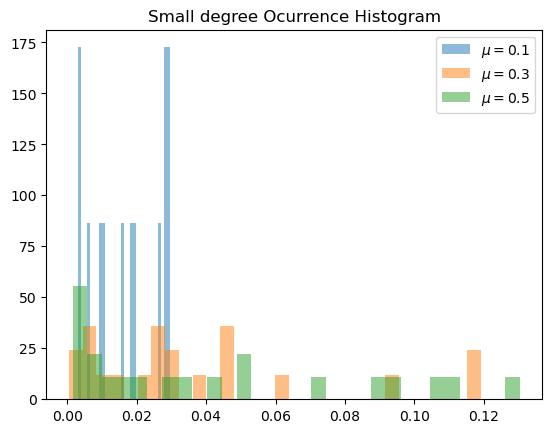

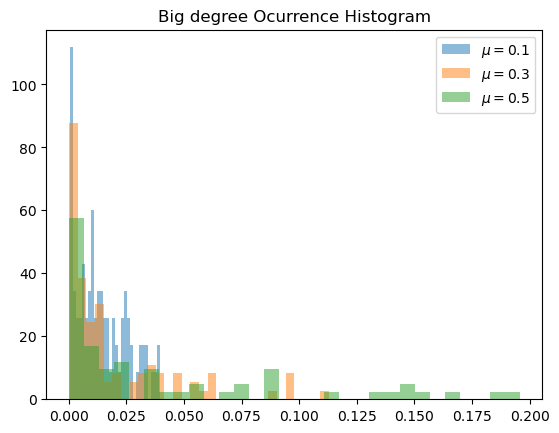

In [33]:
plt.hist(vect00,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(vect01,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(vect02,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Small degree Ocurrence Histogram")
plt.show()

plt.hist(vect10,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(vect11,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(vect12,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Big degree Ocurrence Histogram")
plt.show()

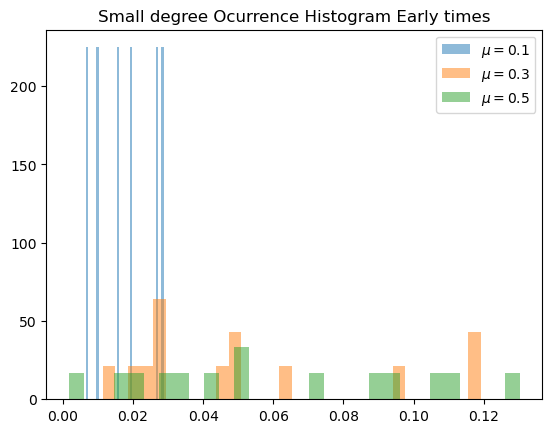

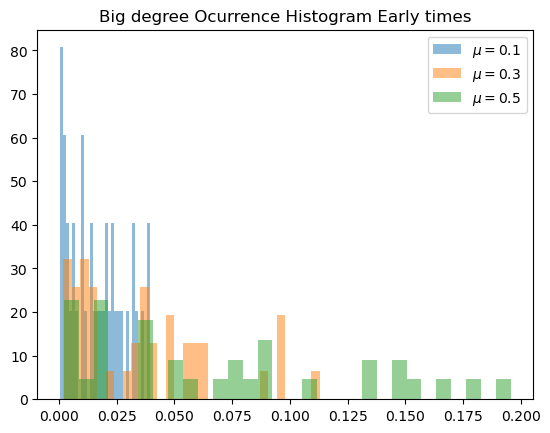

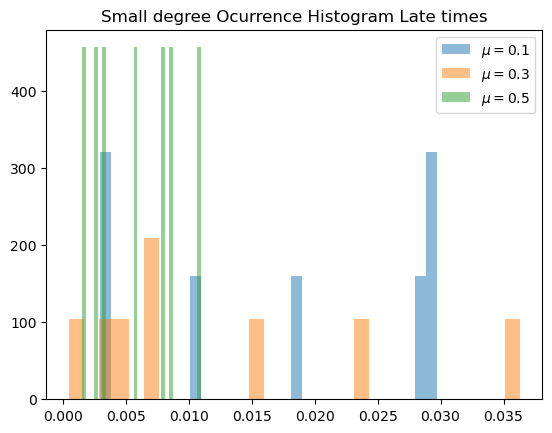

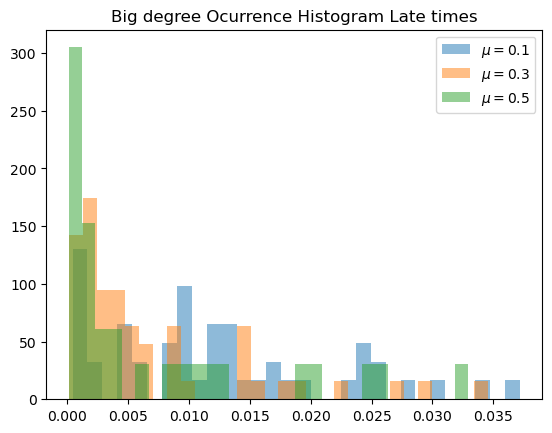

In [34]:
opin00hp = []
opin01hp = []
opin02hp = []
opin10hp = []
opin11hp = []
opin12hp = []
opin00hg = []
opin01hg = []
opin02hg = []
opin10hg = []
opin11hg = []
opin12hg = []

for i in range(0,len(vect00)):
    if(t00[i]<15):
        opin00hp.append(vect00[i])
for i in range(0,len(vect01)):
    if(t01[i]<15):
        opin01hp.append(vect01[i])
for i in range(0,len(vect02)):
    if(t02[i]<15):
        opin02hp.append(vect02[i])
for i in range(0,len(vect10)):
    if(t10[i]<15):
        opin10hp.append(vect10[i])
for i in range(0,len(vect11)):
    if(t11[i]<15):
        opin11hp.append(vect11[i])
for i in range(0,len(vect12)):
    if(t12[i]<15):
        opin12hp.append(vect12[i])

for i in range(0,len(vect00)):
    if(t00[i]>15):
        opin00hg.append(vect00[i])
for i in range(0,len(vect01)):
    if(t01[i]>15):
        opin01hg.append(vect01[i])
for i in range(0,len(vect02)):
    if(t02[i]>15):
        opin02hg.append(vect02[i])
for i in range(0,len(vect10)):
    if(t10[i]>15):
        opin10hg.append(vect10[i])
for i in range(0,len(vect11)):
    if(t11[i]>15):
        opin11hg.append(vect11[i])
for i in range(0,len(vect12)):
    if(t12[i]>15):
        opin12hg.append(vect12[i])

        
plt.hist(opin00hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin01hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin02hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Small degree Ocurrence Histogram Early times")
plt.savefig('smalldegearlysym')
plt.show()

plt.hist(opin10hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin11hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin12hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Big degree Ocurrence Histogram Early times")
plt.savefig('bigdegearlysym')
plt.show()

plt.hist(opin00hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin01hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin02hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Small degree Ocurrence Histogram Late times")
plt.savefig('smalldeglatesym')
plt.show()

plt.hist(opin10hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin11hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin12hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Big degree Ocurrence Histogram Late times")
plt.savefig('bigdeglatesym')
plt.show()

In [14]:
print(np.round(opin00hg,4))
print(np.round(opin01hg,4))
print(np.round(opin02hg,4))

[0.0027]
[0.0002 0.0003]
[0.0004 0.0001 0.0002 0.0002]


0
100
100
100
1
99
99
99
2
97
97
97
3
84
84
84
4
91
91
91
5
91
91
91
6
89
89
89
7
93
93
93
8
95
95
95
9
89
89
89
10
97
97
97
11
85
85
85
12
97
97
97
13
91
91
91
14
100
100
100
15
13
13
13
16
17
17
17
17
17
17
17
18
21
21
21
19
20
20
20
20
16
16
16
21
19
19
19
22
17
17
17
23
23
23
23
24
17
17
17
25
16
16
16
26
17
17
17
27
23
23
23
28
10
10
10
29
16
16
16


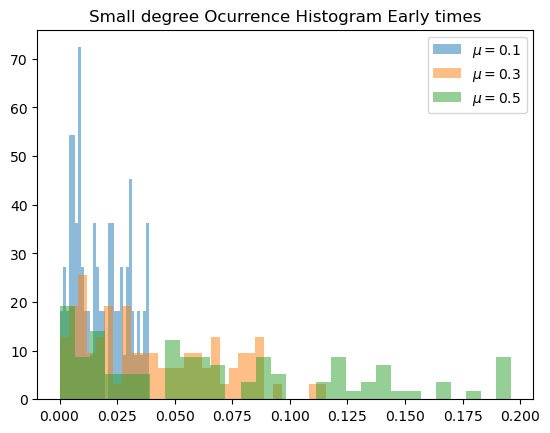

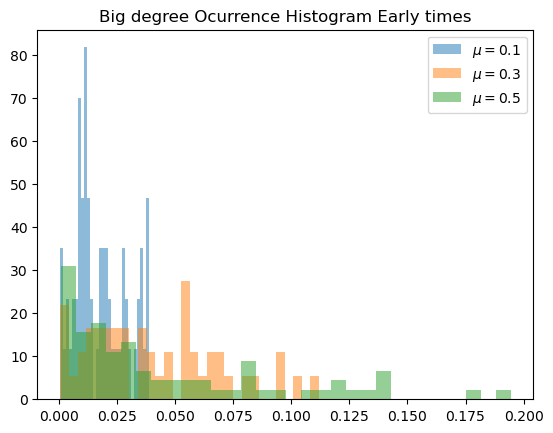

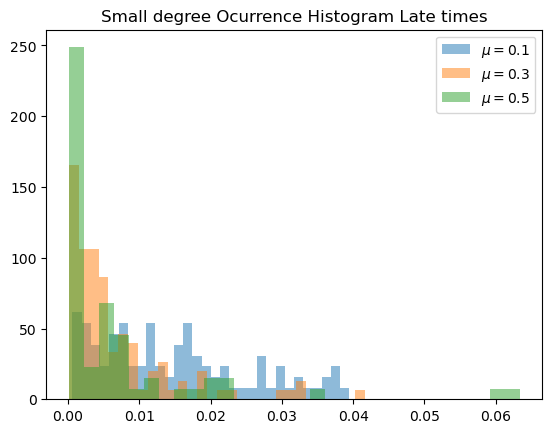

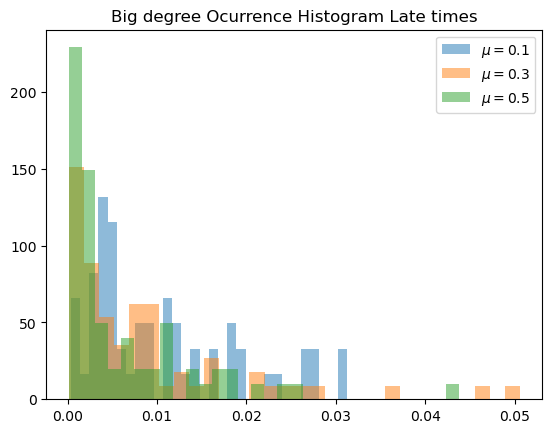

In [18]:
import networkx as nx
net_order = 300
symmetric_updating = True
iterations = 5
average = 1
times = 1000
bins = 50
threshold = 0.4
convergence = np.array([0.1,0.3,0.5])

#Initialize
G = create_network(net_order,p=0.9)
initialopinions = np.zeros((net_order))
rng=np.random.default_rng()
time = compute_iterations(symmetric_updating,iterations,net_order)
opinionnodes = np.zeros((net_order,times,2,3))
t = np.zeros(times)
differences = np.zeros((net_order,times,2,3))
opin00hp = []
opin01hp = []
opin02hp = []
opin10hp = []
opin11hp = []
opin12hp = []
opin00hg = []
opin01hg = []
opin02hg = []
opin10hg = []
opin11hg = []
opin12hg = []

smallnodes = bignodes = 0
t[0] = 0

#Loop for the average over the net_order nodes keeping the opinions at certain times
for k in range(0,30):
    initialopinions = rng.random(G.order())
    print(k)
    for i in range(0,3):
        opinions = initialopinions
        if(k<15):
            node = G.degree[276+k]
        else:
            node = G.degree[k]
        print(node)
        if(node<=35):
            opinionnodes[smallnodes,0,0,i] = initialopinions[node]
        else:
            opinionnodes[bignodes,0,1,i] = initialopinions[node]
        for j in range(1,500):
            _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence[i],
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            if(node<35):
                opinionnodes[smallnodes,j,0,i] = opinions[node]
                differences[smallnodes,j,0,i] = opinionnodes[smallnodes,j,0,i]-opinionnodes[smallnodes,j-1,0,i]
                if(differences[smallnodes,j,0,i]>0.0001):
                    if(i==0):
                        opin00hp.append(differences[smallnodes,j,0,i])
                    if(i==1):
                        opin01hp.append(differences[smallnodes,j,0,i])
                    if(i==2):
                        opin02hp.append(differences[smallnodes,j,0,i])
            else:
                opinionnodes[bignodes,j,1,i] = opinions[node]
                differences[bignodes,j,1,i] = opinionnodes[bignodes,j,1,i]-opinionnodes[bignodes,j-1,1,i]
                if(differences[bignodes,j,1,i]>0.0001):
                    if(i==0):
                        opin10hp.append(differences[bignodes,j,1,i])
                    if(i==1):
                        opin11hp.append(differences[bignodes,j,1,i])
                    if(i==2):
                        opin12hp.append(differences[bignodes,j,1,i])
            if(i==0):
                t[j] = time*j
        for j in range(500,1000):
            _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence[i],
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng())
            if(node<35):
                opinionnodes[smallnodes,j,0,i] = opinions[node]
                differences[smallnodes,j,0,i] = opinionnodes[smallnodes,j,0,i]-opinionnodes[smallnodes,j-1,0,i]
                if(differences[smallnodes,j,0,i]>0.0001):
                    if(i==0):
                        opin00hg.append(differences[smallnodes,j,0,i])
                    if(i==1):
                        opin01hg.append(differences[smallnodes,j,0,i])
                    if(i==2):
                        opin02hg.append(differences[smallnodes,j,0,i])
            else:
                opinionnodes[bignodes,j,1,i] = opinions[node]
                differences[bignodes,j,1,i] = opinionnodes[bignodes,j,1,i]-opinionnodes[bignodes,j-1,1,i]
                if(differences[bignodes,j,1,i]>0.0001):
                    if(i==0):
                        opin10hg.append(differences[bignodes,j,1,i])
                    if(i==1):
                        opin11hg.append(differences[bignodes,j,1,i])
                    if(i==2):
                        opin12hg.append(differences[bignodes,j,1,i])
            if(i==0):
                t[j] = time*j
    if(node<35):
        smallnodes+=1
    else:
        bignodes+=1

plt.hist(opin00hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin01hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin02hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Small degree Ocurrence Histogram Early times")
plt.savefig('smalldegearlysym')
plt.show()

plt.hist(opin10hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin11hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin12hp,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Big degree Ocurrence Histogram Early times")
plt.savefig('bigdegearlysym')
plt.show()

plt.hist(opin00hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin01hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin02hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Small degree Ocurrence Histogram Late times")
plt.savefig('smalldeglatesym')
plt.show()

plt.hist(opin10hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.1$")
plt.hist(opin11hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.3$")
plt.hist(opin12hg,bins=30,density=True,alpha=0.5,label=r"$\mu=0.5$")
plt.legend()
plt.title("Big degree Ocurrence Histogram Late times")
plt.savefig('bigdeglatesym')
plt.show()

In [19]:
print(smallnodes,bignodes)

15 15


In [13]:
print(G.degree)

[(0, 21), (1, 12), (2, 23), (3, 17), (4, 19), (5, 17), (6, 20), (7, 15), (8, 18), (9, 19), (10, 21), (11, 30), (12, 13), (13, 20), (14, 15), (15, 18), (16, 18), (17, 18), (18, 18), (19, 21), (20, 20), (21, 13), (22, 20), (23, 24), (24, 16), (25, 19), (26, 15), (27, 13), (28, 16), (29, 20), (30, 15), (31, 20), (32, 11), (33, 17), (34, 22), (35, 16), (36, 20), (37, 14), (38, 14), (39, 18), (40, 17), (41, 14), (42, 15), (43, 12), (44, 15), (45, 18), (46, 17), (47, 13), (48, 20), (49, 16), (50, 21), (51, 20), (52, 19), (53, 24), (54, 19), (55, 19), (56, 21), (57, 16), (58, 18), (59, 18), (60, 17), (61, 14), (62, 18), (63, 18), (64, 19), (65, 16), (66, 17), (67, 16), (68, 18), (69, 18), (70, 18), (71, 19), (72, 11), (73, 16), (74, 16), (75, 24), (76, 18), (77, 11), (78, 16), (79, 16), (80, 18), (81, 19), (82, 18), (83, 15), (84, 21), (85, 15), (86, 14), (87, 15), (88, 15), (89, 15), (90, 19), (91, 10), (92, 13), (93, 19), (94, 22), (95, 19), (96, 19), (97, 17), (98, 18), (99, 18), (100, 14)